In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pomegranate as pom
import pickle
import multiprocessing

In [2]:
import import_ipynb
import readSequenceFunctions as rsf
from baseHMM import createModel3S

importing Jupyter notebook from readSequenceFunctions.ipynb
importing Jupyter notebook from baseHMM.ipynb
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs
{
    "name" :"DiscreteDistribution",
    "frozen" :false,
    "class" :"Distribution",
    "dtype" :"int",
    "parameters" :[
        {
            "3" :0.2,
            "0" :0,
            "1" :0.3,
            "2" :0.5
        }
    ]
}
{
    "name" :"DiscreteDistribution",
    "frozen" :false,
    "class" :"Distribution",
    "dtype" :"int",
    "parameters" :[
        {
            "3" :0.2,
            "0" :0,
            "1" :0.29,
            "2" :0.51
        }
    ]
}
{
    "name" :"DiscreteDistribution",
    "frozen" :false,
    "class" :"Distribution",
    "dtype" :"int",
    "parameters" :[
        {
            "3" :0.2,
            "0" :0,
            "1" :0.3,
            "2" :0.5
        }
    ]
}
{
    "name" :"DiscreteDistribution",
   

In [3]:
np.set_printoptions(precision=5, linewidth=120, suppress=True)

## Dataset

actualCoding=1
rsf.usedCoding.changeCoding(actualCoding)

seqDict,seqDictT,trainList,trainNamesList,testList,testNamesList=\
        rsf.traindAndTestDataset(rsf.pathsBCE, testSize=50)

## Initialization of HMM

In [4]:
def randomDistr(n, generator=None):
    """Create random DiscreteDistribution, which create integers from 0 to n-1"""
    d={}
    if generator is not None:
        generatedList=generator.uniform(size=n)
    else:
        generatedList=np.random.rand(n)
    sumOfList=np.sum(generatedList)
    generatedList/=sumOfList
    for i in range(n):
        d[i]=generatedList[i]
    return pom.DiscreteDistribution(d)

In [5]:
def emptyDistr(n):
    """Create DiscreteDistribution which generate nothing, with possible value from 0 to n-1."""
    d={}
    for i in range(n):
        d[i]=0
    return pom.DiscreteDistribution(d)

In [6]:
def endDistr(n):
    """Crete DiscreteDistribution which generate only stop codons."""
    d={}
    for i in range(n):
        d[i]=0
    d[rsf.usedCoding.stopCodonsSymbol]=1
    return pom.DiscreteDistribution(d)

In [7]:
def initializeHMM(n=100, initialEnd=0.01, generator=None):
    #testGenerator=np.random.default_rng(seed=20200201)
    
    distrList=[emptyDistr(4)]*n
    distrList[0]=endDistr(4)
    distrList[1]=randomDistr(4,generator=generator)

    #state 0 generate end
    #state 1 is initial only generating state
    transMatrix=np.zeros((n,n))
    transMatrix[1,1]=1-initialEnd
    transMatrix[1,0]=initialEnd
    
    start=np.zeros(n)
    start[1]=1
    
    end=np.zeros(n)
    end[0]=1

    return pom.HiddenMarkovModel.from_matrix(transMatrix,distrList,start,end)

## Spliting states

In [8]:
def entropy(distr):
    if not isinstance(distr, pom.DiscreteDistribution):
        raise RuntimeError("Entropy becamed distribution diffrent from pom.DiscreteDistribution")
    probability=distr.parameters[0]
    ent=0
    for key,prob in probability.items():
        if prob!=0:
            ent+=prob*np.log(prob)
    ent*=(-1)
    return ent

In [9]:
def splitDistribution(distr, generator=None):
    """Split distr in two distribution such that distr=alfa*distr1+(1-alfa)*distr2"""
    keys=distr.keys()
    probabilities=np.array(distr.values())
    if generator is not None:
        relations=generator.uniform(low=0, high=1, size=len(keys))
    else:
        relations=np.random.rand(len(keys))
    
    prob1=probabilities*relations
    prob2=probabilities-prob1
    
    alfa=np.sum(prob1)
    
    prob1/=alfa
    prob2/=(1-alfa)
    
    d1={}
    d2={}
    
    for i in range(len(keys)):
        d1[keys[i]]=prob1[i]
        d2[keys[i]]=prob2[i]
    
    return(alfa,pom.DiscreteDistribution(d1),pom.DiscreteDistribution(d2))

In [10]:
def splitState(model, generator=None):
    maxIndex=-1;
    maxEntr=-1;
    startIndex=None
    endIndex=None
    distributions=[model.states[0].distribution]
    for i in range(1,len(model.states)):
        if model.states[i].name=="None-start":
            startIndex=i
            distributions.append(model.states[i].distribution)
            continue
        if model.states[i].name=="None-end":
            endIndex=i
            distributions.append(model.states[i].distribution)
            continue
        distributions.append(model.states[i].distribution)
        ent=entropy(model.states[i].distribution)
        if maxEntr<ent:
            maxEntr=ent
            maxIndex=i
    (alfa, distr1, distr2)=splitDistribution(model.states[maxIndex].distribution, generator=generator)
    
    #print("Alfa:",alfa)
    
    distributions[maxIndex]=distr1
    distributions.append(distr2)
    
    matrix=np.copy(model.dense_transition_matrix())
    matrix=np.vstack((matrix,np.zeros(matrix.shape[0])))
    matrix=np.hstack((matrix,np.zeros((matrix.shape[0],1))))
    
    #copy in probabilities
    matrix[:,-1]=matrix[:,maxIndex]
    
    #copy out probabilities
    matrix[-1,:]=matrix[maxIndex,:]
    
    #modify in probabilities with alfa
    matrix[:,maxIndex]*=alfa
    matrix[:,-1]*=(1-alfa)
    
    #save list of transition from start and to stop
    end=np.copy(matrix[:,endIndex])
    start=np.copy(matrix[startIndex,:])
    
    #remove state-stop and state-start
    matrix[:,endIndex]=np.zeros(matrix.shape[0])
    matrix[startIndex,:]=np.zeros(matrix.shape[1])
    
   # print(matrix)
   # print(len(distributions))
   # print(start)
   # print(end)
    return pom.hmm.HiddenMarkovModel.from_matrix(matrix, distributions, start,end)

In [11]:
def createStates(model, learningList, testingList, n=32,stopTreshold=10, verbose=0,
                savePrefix="Modele/m"):
    if verbose>=2:
        fitVerbose=True
    else:
        fitVerbose=False    
    
    testGenerator=np.random.default_rng(seed=2020020114)
    
    results1=[]
    results3=[]
    model.fit(learningList,stop_threshold=stopTreshold, verbose=fitVerbose)
    
    with open(savePrefix+"0.store","wb") as file:
        pickle.dump(model,file)
        
    scores1S=[model.log_probability(seq) for seq in testingList]
    scores1S=np.array(scores1S)
    
    if verbose>=3:
        print(model.dense_transition_matrix())
    
    model3S=createModel3S(1)
    model3S.fit(learningList,stop_threshold=stopTreshold, verbose=fitVerbose)
    
    scores3S=[model3S.log_probability(seq) for seq in testingList]
    scores3S=np.array(scores3S)
    
    for i in range(1,n):
        model=splitState(model,generator=testGenerator)
        if n>15:
            model.fit(learningList,stop_threshold=stopTreshold, n_jobs=-1, verbose=fitVerbose)
        else:
            model.fit(learningList,stop_threshold=stopTreshold, verbose=fitVerbose)
        
        scoresModel=[model.log_probability(seq) for seq in testingList]
        scoresModel=np.array(scoresModel)
        scoresModel1=scoresModel-scores1S
        scoresModel3=scoresModel-scores3S
        results1.append(np.mean(scoresModel1))
        results3.append(np.mean(scoresModel3))
        
        with open(savePrefix+str(i+1)+".store","wb") as file:
            pickle.dump(model,file)
            
        if verbose>=1:
            print("End of step:",i+1)
        
        if verbose>=3:
            print(model.dense_transition_matrix())
        
    return {"results1":results1,"results3":results3,"scores1":scores1S,"scores3":scores3S}

In [12]:
def mpUnitTest(generator, n):
    seqDict,seqDictT,trainList,trainNamesList,testList,testNamesList=\
                    rsf.traindAndTestDataset(rsf.pathsBCE, testSize=400, generator=generator)
    result=createStates(initializeHMM(generator=generator),trainList,testList,n=9,
                        savePrefix="Modele/m-"+str(n)+"-", verbose=2,stopTreshold=1)
        
    with open("Modele/result-"+str(n),"wb") as file:
        pickle.dump(result,file)
    return

In [13]:
def test():
    actualCoding=1
    rsf.usedCoding.changeCoding(actualCoding)

    generators=[np.random.default_rng(100240),np.random.default_rng(100250),np.random.default_rng(100255),
               np.random.default_rng(100315)]
    inputData=zip(generators,range(1,5))
    with multiprocessing.Pool(4) as pool:
        pool.starmap(mpUnitTest,inputData)
            

In [14]:
test()

[1] Improvement: 2192662.8800146366	Time (s): 2.909
[1] Improvement: 2393477.018525748	Time (s): 2.931
[1] Improvement: 673867.0261185763	Time (s): 2.927
[1] Improvement: 670188.6018730276	Time (s): 3.012
[2] Improvement: -1.3527460396289825e-07	Time (s): 2.964
Total Training Improvement: 2393477.0185256125
Total Training Time (s): 8.8209
[2] Improvement: -1.6647391021251678e-07	Time (s): 2.958
Total Training Improvement: 673867.0261184098
Total Training Time (s): 8.8297
[2] Improvement: -3.5157427191734314e-08	Time (s): 3.073
Total Training Improvement: 2192662.880014601
Total Training Time (s): 8.9048
[2] Improvement: 6.100162863731384e-08	Time (s): 3.001
Total Training Improvement: 670188.6018730886
Total Training Time (s): 8.9742
[1] Improvement: 65806.06785353948	Time (s): 3.949
[1] Improvement: 66220.0128707448	Time (s): 3.99
[1] Improvement: 66479.63381476374	Time (s): 4.009
[2] Improvement: 755.8967216170859	Time (s): 3.975
[2] Improvement: 743.7644421679433	Time (s): 3.974
[2]

[37] Improvement: 1.3526635312009603	Time (s): 4.032
[37] Improvement: 1.3138780184090137	Time (s): 4.043
[36] Improvement: 1.5293622890021652	Time (s): 4.016
[38] Improvement: 1.4317622394300997	Time (s): 3.96
[38] Improvement: 1.2334655513986945	Time (s): 4.033
[38] Improvement: 1.2006618026643991	Time (s): 4.002
[37] Improvement: 1.3732859860174358	Time (s): 3.999
[39] Improvement: 1.294691875576973	Time (s): 3.996
[39] Improvement: 1.1391922624316067	Time (s): 4.014
[39] Improvement: 1.1111601241864264	Time (s): 4.052
[38] Improvement: 1.2427182481624186	Time (s): 4.065
[40] Improvement: 1.1780226978007704	Time (s): 4.043
[40] Improvement: 1.0679577223490924	Time (s): 4.022
[40] Improvement: 1.0434724532533437	Time (s): 4.08
[39] Improvement: 1.1352995401248336	Time (s): 4.049
[41] Improvement: 1.080328875221312	Time (s): 4.004
[41] Improvement: 1.0183187080547214	Time (s): 3.981
[41] Improvement: 0.9961671531200409	Time (s): 4.093
Total Training Improvement: 69514.36646280042
Tota

[32] Improvement: 7.2319568584207445	Time (s): 3.589
[33] Improvement: 7.081838939804584	Time (s): 3.548
[34] Improvement: 6.9861954662483186	Time (s): 3.666
[34] Improvement: 6.823503241874278	Time (s): 3.58
[33] Improvement: 7.1107835348229855	Time (s): 3.692
[34] Improvement: 6.9688960465136915	Time (s): 3.567
[35] Improvement: 6.879504575626925	Time (s): 3.647
[35] Improvement: 6.7134359397459775	Time (s): 3.569
[34] Improvement: 6.995349594624713	Time (s): 3.67
[35] Improvement: 6.861651766579598	Time (s): 3.555
[36] Improvement: 6.778339411597699	Time (s): 3.652
[36] Improvement: 6.609026061138138	Time (s): 3.617
[35] Improvement: 6.885759516619146	Time (s): 3.659
[36] Improvement: 6.760121110128239	Time (s): 3.562
[37] Improvement: 6.510226384969428	Time (s): 3.597
[37] Improvement: 6.682639139471576	Time (s): 3.689
[36] Improvement: 6.782028941204771	Time (s): 3.685
[37] Improvement: 6.66424088855274	Time (s): 3.596
[38] Improvement: 6.592275897273794	Time (s): 3.628
[38] Impro

[73] Improvement: 4.637225244892761	Time (s): 3.612
[72] Improvement: 4.857267427956685	Time (s): 3.618
[73] Improvement: 4.787956333020702	Time (s): 3.691
[73] Improvement: 4.807758432580158	Time (s): 3.599
[74] Improvement: 4.593375755706802	Time (s): 3.603
[73] Improvement: 4.811713769333437	Time (s): 3.664
[74] Improvement: 4.740930986823514	Time (s): 3.663
[74] Improvement: 4.761526813963428	Time (s): 3.57
[75] Improvement: 4.549517223611474	Time (s): 3.618
[74] Improvement: 4.76608067099005	Time (s): 3.668
[75] Improvement: 4.693866671761498	Time (s): 3.664
[75] Improvement: 4.715222980827093	Time (s): 3.591
[76] Improvement: 4.505687788128853	Time (s): 3.612
[75] Improvement: 4.720412193564698	Time (s): 3.62
[76] Improvement: 4.668893639463931	Time (s): 3.57
[76] Improvement: 4.646808223798871	Time (s): 3.662
[77] Improvement: 4.461926049087197	Time (s): 3.569
[76] Improvement: 4.6747531541623175	Time (s): 3.637
[77] Improvement: 4.622585854725912	Time (s): 3.59
[77] Improvement

[112] Improvement: 3.2722308293450624	Time (s): 3.637
[111] Improvement: 3.3381592913065106	Time (s): 3.715
[112] Improvement: 3.2300260928459466	Time (s): 3.653
[113] Improvement: 3.1664575282484293	Time (s): 3.612
[113] Improvement: 3.2450427708681673	Time (s): 3.603
[112] Improvement: 3.311178627423942	Time (s): 3.621
[113] Improvement: 3.202191588236019	Time (s): 3.663
[114] Improvement: 3.1414252317044884	Time (s): 3.576
[114] Improvement: 3.218525093747303	Time (s): 3.619
[113] Improvement: 3.2848600754514337	Time (s): 3.652
[115] Improvement: 3.117004959611222	Time (s): 3.554
[114] Improvement: 3.175019081681967	Time (s): 3.703
[115] Improvement: 3.1926715676672757	Time (s): 3.601
[114] Improvement: 3.259197253268212	Time (s): 3.659
[116] Improvement: 3.0931899338029325	Time (s): 3.618
[115] Improvement: 3.1485029028262943	Time (s): 3.654
[116] Improvement: 3.167475458001718	Time (s): 3.586
[115] Improvement: 3.234183218795806	Time (s): 3.63
[117] Improvement: 3.069972972618416	

[151] Improvement: 2.561399878235534	Time (s): 3.625
[151] Improvement: 2.6173573173582554	Time (s): 3.647
[150] Improvement: 2.560040729586035	Time (s): 3.65
[150] Improvement: 2.6826270681340247	Time (s): 3.685
[152] Improvement: 2.5521540087647736	Time (s): 3.564
[152] Improvement: 2.6082878990564495	Time (s): 3.636
[151] Improvement: 2.5502840992994606	Time (s): 3.635
[151] Improvement: 2.6732489024288952	Time (s): 3.62
[153] Improvement: 2.543089489918202	Time (s): 3.641
[153] Improvement: 2.5994254807010293	Time (s): 3.572
[152] Improvement: 2.5407603678759187	Time (s): 3.628
[152] Improvement: 2.6640641964040697	Time (s): 3.618
[154] Improvement: 2.5341959041543305	Time (s): 3.636
[154] Improvement: 2.5907583199441433	Time (s): 3.691
[153] Improvement: 2.5314572213683277	Time (s): 3.645
[153] Improvement: 2.655061728786677	Time (s): 3.623
[155] Improvement: 2.525463233469054	Time (s): 3.669
[155] Improvement: 2.582274946849793	Time (s): 3.571
[154] Improvement: 2.522362715797499

[190] Improvement: 2.339454695349559	Time (s): 3.56
[190] Improvement: 2.2694302739109844	Time (s): 3.59
[188] Improvement: 2.39579304959625	Time (s): 3.584
[188] Improvement: 2.274711505509913	Time (s): 3.599
[191] Improvement: 2.3330049477517605	Time (s): 3.585
[191] Improvement: 2.2626992780715227	Time (s): 3.554
[189] Improvement: 2.3889985061250627	Time (s): 3.63
[189] Improvement: 2.268100248882547	Time (s): 3.666
[192] Improvement: 2.32655201619491	Time (s): 3.536
[192] Improvement: 2.2559790110681206	Time (s): 3.584
[190] Improvement: 2.382210672600195	Time (s): 3.57
[190] Improvement: 2.261495586950332	Time (s): 3.649
[193] Improvement: 2.3200947805307806	Time (s): 3.618
[193] Improvement: 2.249268701998517	Time (s): 3.597
[191] Improvement: 2.3754284139722586	Time (s): 3.555
[191] Improvement: 2.2548965285532176	Time (s): 3.625
[194] Improvement: 2.3136321038473397	Time (s): 3.608
[192] Improvement: 2.3686507355887443	Time (s): 3.577
[194] Improvement: 2.2425675492268056	Time

[226] Improvement: 2.13397514866665	Time (s): 3.564
[229] Improvement: 2.0768020255491138	Time (s): 3.538
[226] Improvement: 2.022736235987395	Time (s): 3.584
[229] Improvement: 2.0082846810109913	Time (s): 3.556
[227] Improvement: 2.1267675466369838	Time (s): 3.63
[230] Improvement: 2.069569413084537	Time (s): 3.556
[227] Improvement: 2.0159472145605832	Time (s): 3.583
[230] Improvement: 2.001448624068871	Time (s): 3.6
[228] Improvement: 2.1195347227621824	Time (s): 3.573
[231] Improvement: 2.0623054238967597	Time (s): 3.606
[228] Improvement: 2.0091434794012457	Time (s): 3.586
[231] Improvement: 1.994597871787846	Time (s): 3.541
[229] Improvement: 2.112276392057538	Time (s): 3.639
[232] Improvement: 2.055009961593896	Time (s): 3.547
[229] Improvement: 2.0023246547207236	Time (s): 3.696
[232] Improvement: 1.987732189008966	Time (s): 3.602
[230] Improvement: 2.1049922292586416	Time (s): 3.642
[233] Improvement: 2.0476830042898655	Time (s): 3.56
[230] Improvement: 1.9954904937185347	Tim

[267] Improvement: 1.7824912935029715	Time (s): 3.564
[267] Improvement: 1.7378258262760937	Time (s): 3.625
[264] Improvement: 1.7537391409277916	Time (s): 3.661
[265] Improvement: 1.8347719961311668	Time (s): 3.64
[268] Improvement: 1.7743628206662834	Time (s): 3.647
[268] Improvement: 1.7304660405497998	Time (s): 3.541
[265] Improvement: 1.7464011423289776	Time (s): 3.63
[266] Improvement: 1.8267196738161147	Time (s): 3.631
[269] Improvement: 1.7662264253012836	Time (s): 3.521
[269] Improvement: 1.723099772585556	Time (s): 3.624
[266] Improvement: 1.7390555443707854	Time (s): 3.618
[267] Improvement: 1.8186579342000186	Time (s): 3.635
[270] Improvement: 1.7580831050872803	Time (s): 3.554
[270] Improvement: 1.7157276475336403	Time (s): 3.587
[267] Improvement: 1.7317030190024525	Time (s): 3.6
[268] Improvement: 1.8105877123307437	Time (s): 3.606
[271] Improvement: 1.749933886807412	Time (s): 3.613
[271] Improvement: 1.7083502933382988	Time (s): 3.569
[268] Improvement: 1.7243441548198

[305] Improvement: 1.4589251466095448	Time (s): 3.591
[306] Improvement: 1.4682463381905109	Time (s): 3.541
[303] Improvement: 1.5294881388545036	Time (s): 3.622
[302] Improvement: 1.4749906838405877	Time (s): 3.617
[306] Improvement: 1.4517546722199768	Time (s): 3.537
[307] Improvement: 1.4604750485159457	Time (s): 3.514
[304] Improvement: 1.5216666557826102	Time (s): 3.648
[303] Improvement: 1.4678103169426322	Time (s): 3.639
[307] Improvement: 1.4445997958537191	Time (s): 3.581
[308] Improvement: 1.4527267559897155	Time (s): 3.575
[305] Improvement: 1.5138645765837282	Time (s): 3.622
[304] Improvement: 1.4606451718136668	Time (s): 3.649
[308] Improvement: 1.4374609617516398	Time (s): 3.535
[309] Improvement: 1.445001878309995	Time (s): 3.591
[306] Improvement: 1.5060824330430478	Time (s): 3.563
[305] Improvement: 1.4534956344868988	Time (s): 3.737
[309] Improvement: 1.4303384984377772	Time (s): 3.585
[310] Improvement: 1.4373008573893458	Time (s): 3.564
[307] Improvement: 1.49832063

[339] Improvement: 1.221993995597586	Time (s): 3.678
[344] Improvement: 1.193621743004769	Time (s): 3.63
[341] Improvement: 1.2487372478935868	Time (s): 3.587
[345] Improvement: 1.1848406423814595	Time (s): 3.568
[340] Improvement: 1.2155718146823347	Time (s): 3.63
[345] Improvement: 1.1872605397365987	Time (s): 3.585
[342] Improvement: 1.2418584963306785	Time (s): 3.572
[346] Improvement: 1.1781485052779317	Time (s): 3.534
[341] Improvement: 1.20917337667197	Time (s): 3.599
[346] Improvement: 1.1809231229126453	Time (s): 3.539
[343] Improvement: 1.2350074616260827	Time (s): 3.601
[347] Improvement: 1.1714861551299691	Time (s): 3.527
[342] Improvement: 1.2027987379115075	Time (s): 3.602
[347] Improvement: 1.1746095523703843	Time (s): 3.558
[344] Improvement: 1.2281841763760895	Time (s): 3.592
[348] Improvement: 1.1648535400163382	Time (s): 3.567
[343] Improvement: 1.1964479652233422	Time (s): 3.605
[348] Improvement: 1.1683198995888233	Time (s): 3.615
[345] Improvement: 1.2213886037934

End of step: 2
[379] Improvement: 1.006927533308044	Time (s): 3.571
[5] Improvement: 60.29895195947029	Time (s): 5.145
[3] Improvement: 73.6588382916525	Time (s): 5.173
[380] Improvement: 1.0011056526564062	Time (s): 3.602
[6] Improvement: 53.672881779726595	Time (s): 5.108
[4] Improvement: 64.00917536532506	Time (s): 5.17
[381] Improvement: 0.9953112530056387	Time (s): 3.605
Total Training Improvement: 1223.5329684591852
Total Training Time (s): 1383.2041
End of step: 2
[1] Improvement: 113.61311474558897	Time (s): 5.136
[7] Improvement: 48.04927095095627	Time (s): 5.147
[5] Improvement: 56.58819286734797	Time (s): 5.215
[2] Improvement: 90.0940490423236	Time (s): 5.23
[8] Improvement: 43.16819681995548	Time (s): 5.107
[6] Improvement: 50.52744214935228	Time (s): 5.145
[1] Improvement: 119.26630439143628	Time (s): 5.099
[3] Improvement: 75.68348206137307	Time (s): 5.172
[9] Improvement: 38.87227337760851	Time (s): 5.139
[7] Improvement: 45.39024694333784	Time (s): 5.079
[2] Improvemen

[42] Improvement: 2.2410827609710395	Time (s): 5.145
[37] Improvement: 2.6400306506548077	Time (s): 5.116
[39] Improvement: 2.6603137254714966	Time (s): 5.153
[45] Improvement: 1.6604534459766	Time (s): 5.112
[43] Improvement: 2.1043557031080127	Time (s): 5.183
[38] Improvement: 2.4500289240386337	Time (s): 5.173
[40] Improvement: 2.4827870074659586	Time (s): 5.201
[46] Improvement: 1.5724451676942408	Time (s): 5.098
[44] Improvement: 1.9800348188728094	Time (s): 5.144
[39] Improvement: 2.2793736355379224	Time (s): 5.178
[41] Improvement: 2.321879734285176	Time (s): 5.108
[47] Improvement: 1.4930153097957373	Time (s): 5.077
[45] Improvement: 1.8669602698646486	Time (s): 5.193
[40] Improvement: 2.1260547067504376	Time (s): 5.096
[42] Improvement: 2.176000810461119	Time (s): 5.17
[48] Improvement: 1.4212843589484692	Time (s): 5.135
[46] Improvement: 1.7640798254869878	Time (s): 5.189
[41] Improvement: 1.9882683206815273	Time (s): 5.117
[43] Improvement: 2.043709533289075	Time (s): 5.138


[2] Improvement: 1.0537584486883134	Time (s): 17.53
[2] Improvement: 1.0644282661378384	Time (s): 17.61
[4] Improvement: 1.042961755534634	Time (s): 17.37
[3] Improvement: 1.0503619180526584	Time (s): 17.41
[3] Improvement: 1.040279037086293	Time (s): 17.59
[3] Improvement: 1.0503438415471464	Time (s): 17.53
[5] Improvement: 1.0338560990057886	Time (s): 17.38
[4] Improvement: 1.038318463601172	Time (s): 17.34
[4] Improvement: 1.0288497728761286	Time (s): 17.6
[4] Improvement: 1.0384182860143483	Time (s): 17.57
[6] Improvement: 1.0258389401715249	Time (s): 17.33
[5] Improvement: 1.0279952301643789	Time (s): 17.35
[5] Improvement: 1.0189385151024908	Time (s): 17.61
[5] Improvement: 1.0280943978577852	Time (s): 17.49
[7] Improvement: 1.018660232424736	Time (s): 17.42
[6] Improvement: 1.0189679379109293	Time (s): 17.43
[6] Improvement: 1.0101859248243272	Time (s): 17.51
[6] Improvement: 1.0189928321633488	Time (s): 17.56
[8] Improvement: 1.0121434177272022	Time (s): 17.43
[7] Improvement: 

In [15]:
with open("Modele/result-1","rb") as file:
        result1=pickle.load(file)
with open("Modele/result-2","rb") as file:
        result2=pickle.load(file)
with open("Modele/result-3","rb") as file:
        result3=pickle.load(file)
with open("Modele/result-4","rb") as file:
        result4=pickle.load(file)

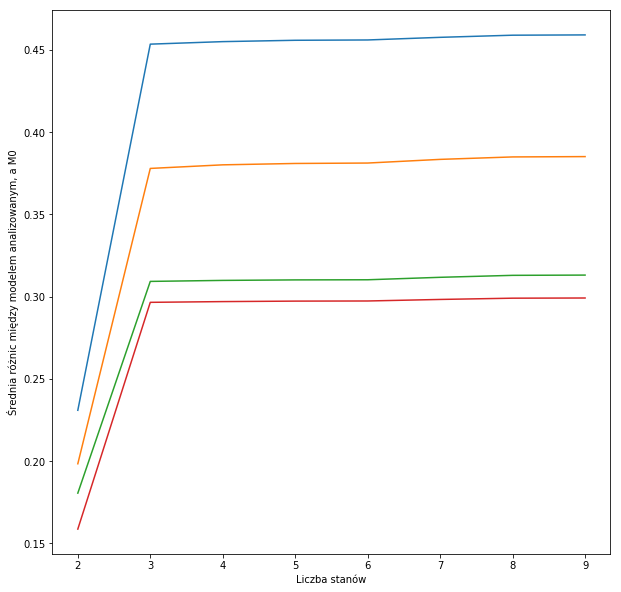

In [16]:
plt.gcf().set_size_inches(10,10)
plt.plot(range(2,10),result1["results1"])
plt.plot(range(2,10),result2["results1"])
plt.plot(range(2,10),result3["results1"])
plt.plot(range(2,10),result4["results1"])
plt.xlabel("Liczba stanów")
plt.ylabel("Średnia różnic między modelem analizowanym, a M0")
plt.savefig("Rys1.png")

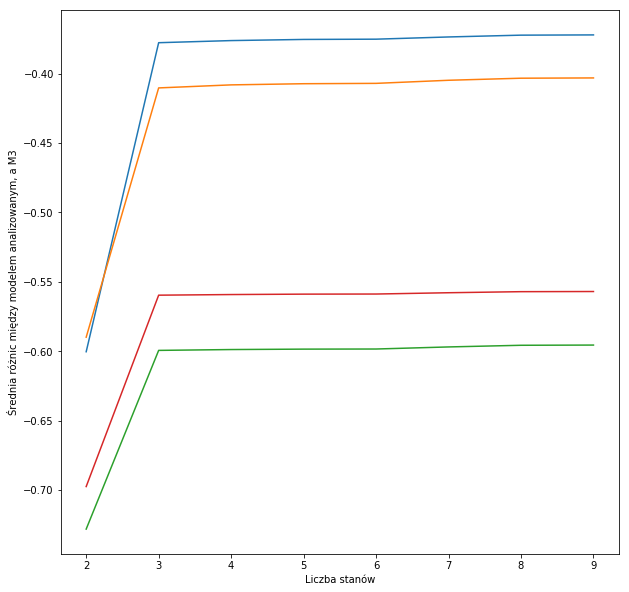

In [17]:
plt.gcf().set_size_inches(10,10)
plt.plot(range(2,10),result1["results3"])
plt.plot(range(2,10),result2["results3"])
plt.plot(range(2,10),result3["results3"])
plt.plot(range(2,10),result4["results3"])
plt.xlabel("Liczba stanów")
plt.ylabel("Średnia różnic między modelem analizowanym, a M3")
plt.savefig("Rys2.png")

In [18]:
R1=result1["scores3"]-result1["scores1"]
R2=result2["scores3"]-result2["scores1"]
R3=result3["scores3"]-result3["scores1"]
R4=result4["scores3"]-result4["scores1"]

In [19]:
print(np.mean(R1))
print(np.mean(R2))
print(np.mean(R3))
print(np.mean(R4))

0.8312773156390708
0.7882780151442009
0.9086757466021969
0.8561696449597511


|Próba|Średnia różnica między M3 a M0|
|-|-|
|1|0.9256|
|2|0.7300|
|3|0.7603|
|---|----------------|
|1|0.8312|
|2|0.7882|
|3|0.9086|
|4|0.8561|

In [20]:
plt.gcf().set_size_inches(10,10)
plt.scatter(range(400),R1)
plt.scatter(range(400),R2)
plt.scatter(range(400),R3)
plt.xlabel("Sekwencja testowa")
plt.ylabel("Różnica na kolejnych sekwencjach testowych między M0 a M3")

Text(0, 0.5, 'Różnica na kolejnych sekwencjach testowych między M0 a M3')

In [21]:
with open("Modele/m-1-7.store","rb") as file:
        m7=pickle.load(file)

m7.dense_transition_matrix()

array([[0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 1.     ],
       [0.00182, 0.53078, 0.01886, 0.04979, 0.28256, 0.01305, 0.07262, 0.03052, 0.     , 0.     ],
       [0.00735, 0.48331, 0.02547, 0.02998, 0.37316, 0.01872, 0.04401, 0.01801, 0.     , 0.     ],
       [0.0022 , 0.50043, 0.02349, 0.03631, 0.34623, 0.01627, 0.05292, 0.02214, 0.     , 0.     ],
       [0.00578, 0.48644, 0.02482, 0.02784, 0.37978, 0.01751, 0.04071, 0.01712, 0.     , 0.     ],
       [0.00675, 0.47393, 0.02538, 0.02999, 0.38252, 0.01915, 0.04412, 0.01816, 0.     , 0.     ],
       [0.00219, 0.49952, 0.02347, 0.0363 , 0.34712, 0.0163 , 0.05294, 0.02215, 0.     , 0.     ],
       [0.00208, 0.50281, 0.02343, 0.03514, 0.34809, 0.01561, 0.05091, 0.02193, 0.     , 0.     ],
       [0.     , 1.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ]])

In [22]:
with open("Modele/m-1-4.store","rb") as file:
        m4=pickle.load(file)

m4.dense_transition_matrix()

array([[0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 1.     ],
       [0.00183, 0.53101, 0.03192, 0.15272, 0.28252, 0.     , 0.     ],
       [0.0063 , 0.48525, 0.04322, 0.0879 , 0.37733, 0.     , 0.     ],
       [0.00227, 0.49918, 0.0395 , 0.11084, 0.34821, 0.     , 0.     ],
       [0.00582, 0.48749, 0.04243, 0.08542, 0.37884, 0.     , 0.     ],
       [0.     , 1.     , 0.     , 0.     , 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ]])

In [23]:
with open("Modele/m-1-5.store","rb") as file:
        m5=pickle.load(file)

m5.dense_transition_matrix()

array([[0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 1.     ],
       [0.00183, 0.531  , 0.01887, 0.15279, 0.28245, 0.01305, 0.     , 0.     ],
       [0.00662, 0.48473, 0.02553, 0.08916, 0.37598, 0.01799, 0.     , 0.     ],
       [0.00224, 0.49945, 0.02338, 0.1109 , 0.34786, 0.01617, 0.     , 0.     ],
       [0.0058 , 0.4871 , 0.02499, 0.08546, 0.37927, 0.01738, 0.     , 0.     ],
       [0.00643, 0.4816 , 0.02549, 0.08933, 0.37901, 0.01814, 0.     , 0.     ],
       [0.     , 1.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ]])

In [24]:
m5.states

[{
     "distribution" : {
         "parameters" : [
             {
                 "3" : 1.0,
                 "2" : 0.0,
                 "0" : 0.0,
                 "1" : 0.0
             }
         ],
         "frozen" : false,
         "class" : "Distribution",
         "name" : "DiscreteDistribution",
         "dtype" : "int"
     },
     "weight" : 1.0,
     "name" : "s0",
     "class" : "State"
 }, {
     "distribution" : {
         "parameters" : [
             {
                 "3" : 0.0,
                 "2" : 0.016724598957298685,
                 "0" : 0.8594651117159521,
                 "1" : 0.12381028932675374
             }
         ],
         "frozen" : false,
         "class" : "Distribution",
         "name" : "DiscreteDistribution",
         "dtype" : "int"
     },
     "weight" : 1.0,
     "name" : "s1",
     "class" : "State"
 }, {
     "distribution" : {
         "parameters" : [
             {
                 "3" : 0.0,
                 "2" : 0.02393804145

In [28]:
with open("Modele/m-1-9.store","rb") as file:
        m9=pickle.load(file)

m9.dense_transition_matrix()

array([[0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 1.     ],
       [0.00181, 0.53044, 0.00673, 0.01488, 0.01884, 0.04983, 0.28283, 0.01304, 0.07268, 0.00893, 0.     , 0.     ],
       [0.00187, 0.50713, 0.00482, 0.01035, 0.02346, 0.03358, 0.34947, 0.01475, 0.04816, 0.00641, 0.     , 0.     ],
       [0.00201, 0.50512, 0.00481, 0.01063, 0.02351, 0.03489, 0.34685, 0.01543, 0.05038, 0.00638, 0.     , 0.     ],
       [0.00803, 0.48183, 0.00397, 0.00894, 0.0254 , 0.03084, 0.37078, 0.01939, 0.04556, 0.00525, 0.     , 0.     ],
       [0.00216, 0.50158, 0.00486, 0.0108 , 0.02358, 0.0364 , 0.34491, 0.01629, 0.05299, 0.00644, 0.     , 0.     ],
       [0.00576, 0.48605, 0.00379, 0.00834, 0.02471, 0.0279 , 0.37987, 0.01767, 0.0409 , 0.00502, 0.     , 0.     ],
       [0.00701, 0.46746, 0.00404, 0.00899, 0.02531, 0.03072, 0.38553, 0.02003, 0.04555, 0.00535, 0.     , 0.     ],
       [0.00215, 0.49982, 0.00486, 0.01081, 0.02356, 0.03641, 0.

In [29]:
m9.states

[{
     "distribution" : {
         "parameters" : [
             {
                 "3" : 1.0,
                 "2" : 0.0,
                 "0" : 0.0,
                 "1" : 0.0
             }
         ],
         "frozen" : false,
         "class" : "Distribution",
         "name" : "DiscreteDistribution",
         "dtype" : "int"
     },
     "weight" : 1.0,
     "name" : "s0",
     "class" : "State"
 }, {
     "distribution" : {
         "parameters" : [
             {
                 "3" : 0.0,
                 "2" : 0.015152673968386696,
                 "0" : 0.8628043037064121,
                 "1" : 0.12204302232520023
             }
         ],
         "frozen" : false,
         "class" : "Distribution",
         "name" : "DiscreteDistribution",
         "dtype" : "int"
     },
     "weight" : 1.0,
     "name" : "s1",
     "class" : "State"
 }, {
     "distribution" : {
         "parameters" : [
             {
                 "3" : 0.0,
                 "2" : 0.33808111929